In [1]:
!pip install datasets openai pillow matplotlib loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfu

## 準備

In [2]:
# ベースライン実装のリポジトリをclone
!git clone https://github.com/ryokan0123/yans-2024-hackathon-baseline
# utilsをノートブックで使用するため、フォルダを移動
!cp -r yans-2024-hackathon-baseline/utils ./

Cloning into 'yans-2024-hackathon-baseline'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 69 (delta 36), reused 58 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (69/69), 82.42 KiB | 819.00 KiB/s, done.
Resolving deltas: 100% (36/36), done.


In [3]:
# OpenAI APIキーを設定
%env OPENAI_API_KEY=sk-...

env: OPENAI_API_KEY=sk-...


In [5]:
# notebook上でOpenAI APIを非同期でまとめて呼び出す場合に必要
import nest_asyncio

nest_asyncio.apply()

In [6]:
# google driveをマウントし、推論結果ファイルをそこに保存できるようにしておく
from google.colab import drive

drive.mount("./drive")

Mounted at ./drive


In [7]:
# ドライブが正しくマウントできているか確認
!ls ./drive/MyDrive

...


## データセットの確認

In [10]:
from datasets import load_dataset

dataset = load_dataset("YANS-official/senryu-debug", split="test")
dataset

Generating test split:   0%|          | 0/2 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'odai_id', 'odai', 'type', 'responses'],
    num_rows: 2
})

image_to_text
写真で一句


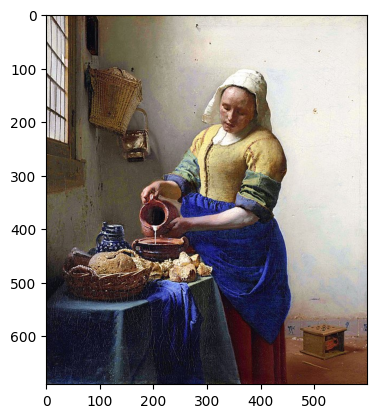


text_to_text
機械学習川柳



In [11]:
import matplotlib.pyplot as plt

for item in dataset:
  print(item["type"])
  print(item["odai"])
  if "image" in item["type"]:
    plt.imshow(item["image"])
    plt.show()
  print()

## 提出ファイルの作成

In [12]:
import datasets
import json
from typing import Any
import argparse
import tqdm
from loguru import logger

from utils.chatgpt import OpenAIChatAPI
from utils.data_util import batch_iter, encode_image_to_base64

In [13]:
def item_to_api_input(item: dict[str, Any]) -> list[dict[str, Any]]:
    """
    川柳データセットの各アイテムを ChatGPT API への入力形式に変換する関数。
    例としてシンプルなプロンプトを実装していますが、適宜変更して使用してください。
    """
    messages = [
        {
            "role": "system",
            "content": "あなたは川柳 AI です。与えられたお題に対して、一句詠んでください。",
        }
    ]
    if item["type"] == "text_to_text":
        # テキストのみを入力としたお題
        messages.append(
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": item["odai"]},
                ],
            }
        )

    elif item["type"] == "image_to_text":
        # ローカルの画像を OpenAI API に渡す場合は、画像を base64 エンコードした文字列を渡す
        # `encode_image_to_base64`で PIL 形式の画像を base64 エンコードした文字列に変換
        image_base64 = encode_image_to_base64(item["image"])

        # 画像で一言のお題
        messages.append(
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "次の画像にちなんで、一句詠んでください。",
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"},
                    },
                ],
            }
        )
    else:
        raise ValueError(f"Invalid type: {item['type']}")

    return messages

In [14]:
dataset_name = "YANS-official/senryu-debug"
batch_size = 4
output_file = "./drive/MyDrive/submission.jsonl"

logger.info(f"Loading data from {dataset_name}...")
dataset = datasets.load_dataset(dataset_name, split="test")

openai_api = OpenAIChatAPI()

logger.info("Generating model outputs...")
# バッチごとにモデルの出力を取得
model_outputs: list[dict[str, Any]] = []
with tqdm.tqdm(total=len(dataset)) as pbar:
    for i, items in enumerate(batch_iter(dataset, batch_size=batch_size)):
        api_input_list = [item_to_api_input(item) for item in items]
        responses = openai_api.batch_generate_chat_response(api_input_list)
        model_outputs += [
            {**item, "model_output": res} for item, res in zip(items, responses)
        ]
        pbar.update(len(items))

logger.info(f"Saving model outputs to {output_file}...")
# モデルの出力を保存
with open(output_file, "w") as f:
    for output in model_outputs:
        output.pop("image")  # 画像は出力に含めない
        f.write(json.dumps(output, ensure_ascii=False, default=str) + "\n")

2024-08-30 12:52:02.043 | INFO     | __main__:<cell line: 5>:5 - Loading data from YANS-official/senryu-debug...
2024-08-30 12:52:03.016 | INFO     | __main__:<cell line: 10>:10 - Generating model outputs...
100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
2024-08-30 12:52:05.743 | INFO     | __main__:<cell line: 22>:22 - Saving model outputs to ./drive/MyDrive/submission.jsonl...
